# 머신러닝 심화 모델

## 실습 개요

머신러닝 심화 모델

1) 실습 목적 <br>
- 이번 실습에서는 GBM기반의 대표적인 알고리즘들 중, LightGBM을 이용한 학습을 진행합니다. <br>
- LightGBM API들을 사용해보고, 그에 맞는 데이터셋 조정과 Parameter를 통한 여러 방면의 성능조절을 경험합니다.

2) 수강 목표
  - LightGBM을 이용해 학습할 수 있습니다.
  - LightGBM사용 시, parameter를 활용한 성능 개선 방법을 이해할 수 있습니다.
  - 시각화를 통해 학습된 모델의 구조를 더욱 잘 파악할 수 있습니다.

### 실습 목차

* **1. 실습 데이터 준비**
  * 데이터 불러오기 및 전처리
* **2. LightGBM 실습**
  * 모델 학습
  * Parameters
  * 시각화

### 데이터셋 개요
* 데이터셋: Yahoo Finance OHLCV 데이터셋이란? (Open High Close Low Volume)
* 데이터셋 개요 : **Yahoo Finance는 주식, 환율과 같은 금융 정보를 제공하는 플랫폼입니다.** 주식과 관련된 정보 및 시각화 정보를 웹사이트를 통해서 제공 (NASDAQ, KOSPI, NIKKEI 등) 됩니다. 데이터는 무료로 사용할 수 있으며, API를 제공하여 손쉽게 데이터를 수집 가능합니다. 또한, Yahoo Finance 정보를 랩핑한 yfinance 패키지를 이용해 파이썬에서도 사용 가능합니다.
  - (O)pen (시가): 주식의 거래가 시작된 가격을 나타냅니다. 시장이 열리면 처음으로 발생한 거래의 가격입니다.
  - (H)igh (고가): 특정 기간 동안 주식의 가격 중 최고점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 높게 거래되었는지를 보여줍니다.
  - (C)lose (종가): 주식의 거래가 마감된 가격을 나타냅니다. 시장이 닫힐 때 주식이 어떤 가격으로 거래를 마쳤는지를 보여줍니다.
  - (L)ow (저가): 특정 기간 동안 주식의 가격 중 최저점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 낮게 거래되었는지를 보여줍니다.
  - (V)Volume (거래량):  특정 기간 동안 거래된 주식의 총 수량을 나타냅니다. 거래량은 주식 시장에서 매우 중요한 지표 중 하나이며, 주식의 유동성과 관련이 있습니다. 더 높은 거래량은 주식 시장의 활발한 거래를 나타낼 수 있습니다.
  - Change (변동률): 이전 주가와 비교해 변화된 변동률 입니다.
  - code (종목 코드): 종목(회사)를 구분하는 코드입니다.
* 데이터셋 저작권 : Apache Software License (Apache)

### 환경 설정
- **패키지 설치 및 임포트**

In [1]:
!uv add scikit-learn numpy lightgbm
!apt-get install -y fonts-nanum
!fc-cache -fv

Resolved 189 packages in 16ms
Audited 88 packages in 12ms
zsh:1: command not found: apt-get
Font directories:
	/System/Library/Assets/com_apple_MobileAsset_Font3
	/System/Library/Assets/com_apple_MobileAsset_Font4
	/System/Library/Fonts
	/Library/Fonts
	/Users/tylersong/Library/Fonts
	/System/Library/AssetsV2/com_apple_MobileAsset_Font8
	/Users/tylersong/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/Users/tylersong/.fonts
	/System/Library/Fonts/Supplemental
	/System/Library/AssetsV2/com_apple_MobileAsset_Font8/00bfc46ccb002b730e29def5116e0a571fb617d8.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font8/0b5bb0a7f7e82279e049e3c943133f4b186ff8a2.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font8/0ebfdb7e5a2a1db668fa6209779e0725d6f6baba.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font8/10e7a462a671950b802274fad767b566ff8457d1.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font8/13b8ce423f920875b28b551f9406bf1014e0a656.asset
	/System/Library

In [2]:
# 계산
import numpy as np

# 전처리
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# 평가
from sklearn.metrics import mean_squared_error

# 모델링
import lightgbm as lgb

from sklearn import tree

# 출력 및 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# tqdm 관련 경고 처리
try:
    from tqdm.auto import tqdm
except ImportError:
    print("tqdm이 설치되어 있지 않습니다. tqdm을 설치해 주세요.")

# 데이터셋 로드 및 정제
import pandas as pd
import itertools
import json
import joblib

# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

# 한글 폰트 설정 (IProgress 및 ipywidgets 미작동 시 별도 경고 출력 없음)
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일 위치
    name='NanumGothic')                        # 폰트명 지정
fm.fontManager.ttflist.insert(0, fe)           # 폰트 리스트에 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

/Users/tylersong/Desktop/workspace/learn/python/offline/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 실습 데이터 준비

```
💡 목차 개요 : GBM과 LightGBM 실습을 위한 데이터를 준비합니다.
```
- **1-1 데이터 불러오기 및 전처리**

### 1-1. 데이터 불러오기 및 전처리


#### 📝 설명 : (1-1)
* LightGBM 학습을 진행하기에 앞서 학습에 사용 될 데이터를 불러옵니다.
* 데이터의 구성을 확인하고, 학습에 알맞는 전처리를 진행합니다.


#### 👨‍💻 코드 : (1-1)


> 이번 실습에서는 금융 도메인의 주가 데이터셋(OHLCV)을 이용합니다.


In [3]:
# OHLCV 데이터셋 불러오기
OHLCV_file = "data/OHLCV.parquet"
OHLCV_data = pd.read_parquet(OHLCV_file)

# 날짜는 데이터셋의 index로 되어 있습니다.
# .loc을 통해서 날짜 범위를 지정해줍시다.
OHLCV_data = OHLCV_data.loc["2020-01-01":"2023-07-31"]

# 상장법인정보 파일도 불러오도록 하겠습니다.
company_file = "data/Company.parquet"
company_data = pd.read_parquet(company_file)

In [4]:
# OHLCV은 종목별 주가와 관련된 정보를 나타내는 데이터셋입니다.
display(OHLCV_data.head(10))

# 상장법인정보 데이터셋입니다.
display(company_data.head(10))

,Open,High,Low,Close,Volume,Change,code
2020-01-02,321000.000000,321000.000000,313500.000000,314000.000000,139496,-0.011024,051910
2020-01-02,38996.097656,38996.097656,37926.585938,38091.125000,190202,-0.021142,000100
2020-01-02,153187.125000,154879.796875,148955.437500,152340.781250,734725,-0.005525,068270
2020-01-02,110659.898438,111675.125000,108121.828125,109137.054688,229273,-0.009217,028260
2020-01-02,658760.312500,668649.312500,647349.937500,651914.062500,71172,-0.010393,207940
2020-01-02,26950.000000,26950.000000,26700.000000,26700.000000,489901,-0.011111,030200
2020-01-02,237000.000000,237500.000000,231500.000000,232000.000000,186494,-0.016949,006400
2020-01-02,36450.000000,36650.000000,35900.000000,35950.000000,1028130,-0.025745,086790
2020-01-02,74400.000000,74800.000000,73000.000000,73100.000000,273967,-0.018792,032830
2020-01-02,44100.000000,44300.000000,42300.000000,42500.000000,1355029,-0.040632,000270


,company,code,industry,products,listing_date,closing_month,region
0,삼성전자,005930,반도체 제조업,"메모리반도체, 시스템LSI",1975-06-11,12월,경기
1,SK하이닉스,000660,반도체 제조업,"DRAM, NAND Flash",1996-12-26,12월,경기
2,NAVER,035420,소프트웨어 개발업,"인터넷 검색, 커머스",2008-11-28,12월,경기
3,카카오,035720,소프트웨어 개발업,"메신저, 포털 서비스",2017-07-10,12월,제주
4,현대자동차,005380,자동차 제조업,"자동차, 차량부품",1974-06-28,12월,서울
5,기아,000270,자동차 제조업,"자동차, 차량부품",1973-07-21,12월,서울
6,LG화학,051910,기초화학물질 제조업,"석유화학, 첨단소재",2001-04-25,12월,서울
7,삼성SDI,006400,일차전지 및 축전지 제조업,"이차전지, 전자재료",1979-03-09,12월,경기
8,삼성바이오로직스,207940,의약품 제조업,바이오의약품 위탁생산,2016-11-10,12월,인천
9,셀트리온,068270,의약품 제조업,바이오시밀러 의약품,2008-09-23,12월,인천


- 이번 실습을 시작하기 전에 우리는 크게 두 가지 성향의 파생 변수를 만들고 시작할거에요.
- 첫 번째는 금융 도메인 지식에 기반해서 파생 변수를 만들고 시작할게요!
- 자칫 어려울수도 있으나, 주가 관련한 금융 도메인에서는 이런 파생 변수가 존재하는걸 인지만하시고 넘어가시면 됩니다.

In [5]:
# 현재 데이터프레임의 인덱스가 날짜로 되어있습니다.
# 분석 편의를 위해서 Date컬럼을 새로 만들고, 인덱스는 새로 초기화 하겠습니다.
OHLCV_data["Date"] = OHLCV_data.index
OHLCV_data["Date"] = pd.to_datetime(OHLCV_data["Date"])
OHLCV_data.reset_index(drop=True, inplace=True)

# 두 파일을 결합시켜 OHCLV와 상장법인정보를 함께 볼수 있도록 하겠습니다.
OHLCV_data = pd.merge(OHLCV_data, company_data, on="code", how="inner")

OHLCV_data["Target"] = OHLCV_data.groupby("code")["Close"].shift(-1)

# 파생 변수1 - 가격 차이를 구합시다.
OHLCV_data["PriceRange"] = OHLCV_data["High"] - OHLCV_data["Low"]
# 파생 변수2 - 종목의 대푯값인 평균 가격를 구합시다.
OHLCV_data["AveragePrice"] = (OHLCV_data["Open"] + OHLCV_data["High"] + OHLCV_data["Low"] + OHLCV_data["Close"]) / 4
# 파생 변수3 - 종가가 시가보다 크면 주가의 방향은 양(1)으로, 반대로 종가가 시가보다 작으면 음(-1)을 표현하도록 하겠습니다.
OHLCV_data['PriceDirection'] = OHLCV_data.apply(lambda row: 1 if row['Close'] > row['Open'] else -1, axis=1)
# 파생 변수4 - 일일 수익률을 계산합니다.
OHLCV_data['DailyReturn'] = OHLCV_data.groupby('code')['Close'].transform(lambda x: x.pct_change() * 100)
# 파생 변수5 - 장기, 중기, 단기 이동평균을 파생변수로 추가합니다.
OHLCV_data["MovingAverage5d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=5).mean())
OHLCV_data["MovingAverage20d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).mean())
OHLCV_data["MovingAverage60d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=60).mean())
OHLCV_data["MovingAverage120d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=120).mean())

# 파생 변수6 - 볼린저 밴드(Bolinger bands)는 이동 평균을 기준으로 상한, 하한 밴드를 구성하여 추세와 변동성을 파악하는 기술입니다.
# 표준편차에 대한 상한 및 하한 밴드의 배수 설정
std_multiplier = 2
std = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).std())
# 상한은 일반적으로 20일 이동평균에 2배의 표준편차 더하기
# 하한은 일반적으로 20일 이동평균에 2배의 표준편차 빼기
OHLCV_data["UpperBollingerBand"] = OHLCV_data["MovingAverage20d"] + (std_multiplier * std)
OHLCV_data["LowerBollingerBand"] = OHLCV_data["MovingAverage20d"] - (std_multiplier * std)

# 파생 변수7 - MACD (Moving Average Convergence & Divergence)는 추가 추세의 힘과 방향성을 파악하여 매매신호를 잡는 목적으로 사용됩니다.
OHLCV_data['ShortEMA'] = OHLCV_data["Close"].ewm(span=12, adjust=False).mean()
OHLCV_data['LongEMA'] = OHLCV_data["Close"].ewm(span=26, adjust=False).mean()
OHLCV_data['MACD'] = OHLCV_data['ShortEMA'] - OHLCV_data['LongEMA']

- 두 번째는 상장법인정보를 기반으로 만들어볼거에요!
- 업종(industry), 주요 제품(products), 상장일(listing_date) 등을 결합해서 새로운 파생 변수를 만들어보도록 하겠습니다.

In [6]:
# 파생 변수8 - OHLCV컬럼 모두 업종별로 일일 평균, 중앙값을 집계해보겠습니다.
# 일별, 업종별로 집계를 해야하기 때문에 두개의 변수(Date, industry)가 집계요소로 들어갑니다.
# 일별 시가의 평균, 중앙값
open_stats = OHLCV_data.groupby(["Date", "industry"])["Open"].agg(["mean", "median"])
open_stats.columns = ["OpenMean", "OpenMedian"]
OHLCV_data = pd.merge(OHLCV_data, open_stats, how="inner", on=["industry", "Date"])
# 일별 고가의 평균, 중앙값
high_stats = OHLCV_data.groupby(["Date", "industry"])["High"].agg(["mean", "median"])
high_stats.columns = ["HighMean", "HighMedian"]
OHLCV_data = pd.merge(OHLCV_data, high_stats, how="inner", on=["industry", "Date"])
# 일별 저가의 평균, 중앙값
low_stats = OHLCV_data.groupby(["Date", "industry"])["Low"].agg(["mean", "median"])
low_stats.columns = ["LowMean", "LowMedian"]
OHLCV_data = pd.merge(OHLCV_data, low_stats, how="inner", on=["industry", "Date"])
# 일별 종가의 평균, 중앙값
close_stats = OHLCV_data.groupby(["Date", "industry"])["Close"].agg(["mean", "median"])
close_stats.columns = ["CloseMean", "CloseMedian"]
OHLCV_data = pd.merge(OHLCV_data, close_stats, how="inner", on=["industry", "Date"])
# 일별 거래량의 평균, 중앙값
volume_stats = OHLCV_data.groupby(["Date", "industry"])["Volume"].agg(["mean", "median"])
volume_stats.columns = ["VolumeMean", "VolumeMedian"]
OHLCV_data = pd.merge(OHLCV_data, volume_stats, how="inner", on=["industry", "Date"])

# 파생 변수 9 - 시간관련 파생 변수
# Date, listing_date컬럼은 "2020-01-01" 형태로 되어있어요.
# 이걸 컴퓨터가 인식할 수 있도록 년,월,일 정수 컬럼으로 나눠서 표현해볼게요.
# Date컬럼 나누기
OHLCV_data["DateYear"] = OHLCV_data["Date"].dt.year
OHLCV_data["DateMonth"] = OHLCV_data["Date"].dt.month
OHLCV_data["DateDay"] = OHLCV_data["Date"].dt.day
# listing_date컬럼 나누기
OHLCV_data["ListingDateYear"] = OHLCV_data["listing_date"].dt.year
OHLCV_data["ListingDateMonth"] = OHLCV_data["listing_date"].dt.month
OHLCV_data["ListingDateDay"] = OHLCV_data["listing_date"].dt.day
# closing_month컬럼은 "12월" 형태이기 때문에 "월"을 빼고 정수만 남기도록 할게요.
OHLCV_data["ClosingMonthInt"] = OHLCV_data["closing_month"].str.replace('월', '').astype(int)

- 학습을 위해서 범주형 변수를 인코딩 하는 작업을 하겠습니다.
- Label Encoding, Frequency Encdoing, Target Encoding

In [7]:
# Label Encoding을 진행합니다.
# sklearn에서 제공하는 LabelEncoder를 활용합시다.
industry_label_encoder = LabelEncoder()
OHLCV_data["LEncodedIndustry"] = industry_label_encoder.fit_transform(OHLCV_data["industry"])

code_label_encoder = LabelEncoder()
OHLCV_data["LEncodedCode"] = code_label_encoder.fit_transform(OHLCV_data["code"])

label_encoder = LabelEncoder()
OHLCV_data["LEncodedProducts"] = label_encoder.fit_transform(OHLCV_data["products"])
OHLCV_data["LEncodedRegion"] = label_encoder.fit_transform(OHLCV_data["region"])

# Frequency Encoding을 진행합니다.
frequency_encoder = OHLCV_data["industry"].value_counts()
OHLCV_data['FEncodedIndustry'] = OHLCV_data['industry'].map(frequency_encoder)

# Target Encoding을 진행합니다.
# 각 업종별 종가의 평균 계산
target_encoder = OHLCV_data.groupby("industry")["Close"].mean()
OHLCV_data["TEncodedIndustry"] = OHLCV_data['industry'].map(target_encoder)

- 마지막으로 결측치와 학습에 불필요한 컬럼들은 모두 제거하겠습니다.

In [8]:
# 결측치 모두 제거
OHLCV_data.dropna(inplace=True)

# OHLCV의 0이 되는 이상치 및 결측치는 모두 제거
OHLCV_data = OHLCV_data[(OHLCV_data[["Open", "High", "Low", "Close", "Volume", "Change"]] != 0).all(axis=1)]

OHLCV_data.drop([
    "company", "industry",
    "products", "listing_date", "closing_month",
    "region", "code"
    ], axis=1, inplace=True)

OHLCV_data.reset_index(drop=True, inplace=True)

In [9]:
# 데이터의 날짜 범위를 알아보도록 하겠습니다.

display(f"데이터셋 날짜 범위: {OHLCV_data['Date'].min()} ~ {OHLCV_data['Date'].max()}")

'데이터셋 날짜 범위: 2020-06-25 00:00:00 ~ 2023-07-28 00:00:00'

In [10]:
train_data = OHLCV_data.loc[OHLCV_data["Date"] < "2023-05-01"].reset_index(drop=True)
valid_data = OHLCV_data.loc[OHLCV_data["Date"] >= "2023-05-01"].reset_index(drop=True)

# Date 컬럼은 이제 필요가 없으니 제거하겠습니다.
train_data.drop("Date", axis=1, inplace=True)
valid_data.drop("Date", axis=1, inplace=True)

display(f"학습세트 : {len(train_data)} 개")
display(f"검증세트 : {len(valid_data)} 개")

'학습세트 : 22552 개'

'검증세트 : 2032 개'

In [11]:
# Target컬럼을 학습 데이터셋에서 제거하도록 하겠습니다.
target_col = "Target"
input_cols = list(train_data.columns)
input_cols.remove(target_col)

display(f"Input Featrue : {input_cols}")
display(f"Target : {target_col}")
print("\n")

# 시계열 데이터이기 때문에 인덱스를 기준으로 train/valid를 분할합니다. (랜덤으로 분할하지 않도록 주의하세요!)
X_train = train_data[input_cols]
Y_train = train_data[target_col]

X_valid = valid_data[input_cols]
Y_valid = valid_data[target_col]

display("학습에 사용할 최종 데이터의 형태는 아래와 같습니다.")
display(f"Train Input : {X_train.shape}")
display(f"Train Target : {Y_train.shape}")
display(f"Valid Input : {X_valid.shape}")
display(f"Valid Target : {Y_valid.shape}")

"Input Featrue : ['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'PriceRange', 'AveragePrice', 'PriceDirection', 'DailyReturn', 'MovingAverage5d', 'MovingAverage20d', 'MovingAverage60d', 'MovingAverage120d', 'UpperBollingerBand', 'LowerBollingerBand', 'ShortEMA', 'LongEMA', 'MACD', 'OpenMean', 'OpenMedian', 'HighMean', 'HighMedian', 'LowMean', 'LowMedian', 'CloseMean', 'CloseMedian', 'VolumeMean', 'VolumeMedian', 'DateYear', 'DateMonth', 'DateDay', 'ListingDateYear', 'ListingDateMonth', 'ListingDateDay', 'ClosingMonthInt', 'LEncodedIndustry', 'LEncodedCode', 'LEncodedProducts', 'LEncodedRegion', 'FEncodedIndustry', 'TEncodedIndustry']"

'Target : Target'

'학습에 사용할 최종 데이터의 형태는 아래와 같습니다.'

'Train Input : (22552, 42)'

'Train Target : (22552,)'

'Valid Input : (2032, 42)'

'Valid Target : (2032,)'

## 2. LightGBM

```
💡 목차 개요 : 실 데이터를 LightGBM을 활용하여 학습 해봅니다.
```
- **2-1 LightGBM 학습**
- **2-2 Parameters**
- **2-3 시각화**

### 2-1. LightGBM 학습
- LightGBM Training API를 활용한 학습/저장/불러오기/추론
- LightGBM Scikit-learn API를 활용한 학습/저장/불러오기/추론

#### 📝 설명 : (2-1)
- 앞서 구성한 데이터셋을 활용해 LightGBM을 학습합니다.
- 학습된 모델을 저장하고 불러오는 과정을 진행합니다.
- 불러온 모델을 사용해 추론을 진행합니다.

<br>
<img src='https://velog.velcdn.com/images/dlehd1989/post/f9c767f9-148d-4cee-ba8d-00bfb0fac1b1/image.png' width="300">
<img src='https://velog.velcdn.com/images/dlehd1989/post/515dc418-938c-43b2-b8fb-756151e3bae2/image.png' width="300">
<br>

- LightGBM에서는 위와 같이 Training APi, Scikit-learn API를 별도로 구분해서 제공하고 있습니다.
- 각 API마다 간단한 학습을 통해 사용법을 익힙니다.

#### 👨‍💻 코드 : (2-1)


- **LightGBM Training API를 활용한 학습/저장/불러오기/추론**

In [12]:
# Training API를 사용하기 위해 LightGBM에서 제공하는 Dataset으로 변환합니다.
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_valid, Y_valid)

In [13]:
# Training API에서는 Parameter를 별도의 Dictionary 형태로 입력을 받습니다.
# 간단한 실습을 위해, 가장 기본적인 Parameter들을 사용합니다.
params = {
    'boosting_type': 'gbdt', # boosting 방법을 지정합니다. gbdt, rf(random forest), dart중 선택할 수 있습니다.
    'objective': 'regression', # 학습의 목적을 지정합니다. regression, binary, multiclass, lambdarank 등 학습의 목적에 따라 지정할 수 있습니다..
    'metric': {'rmse'}, # 평가과정에서의 평가함수를 지정합니다. l1, l2, rmse, auc 등 다양한 metric을 제공합니다.
    'metric_freq': 10, # 몇번의 반복마다 평가를 진행할지 지정합니다.
    'verbosity': 0 # 학습 중 출력할 로그의 레벨을 지정합니다. "< 0"은 Fatal, "0"은 Error(Warning), "1"은 Info, "> 1"은 Debug 레벨의 로그를 출력합니다.
}

In [14]:
# 위에서 선언한 데이터셋과 parameter를 학습을 위한 함수에 적용합니다.
# 기존의 모델 파일이 있을 경우 삭제하여 중복 저장 문제를 방지합니다.
import os
model_path = 'lightgbm_training_api.pkl'
if os.path.exists(model_path):
    os.remove(model_path)

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid], # 평가과정을 진행할 데이터셋을 지정합니다.
    callbacks=[lgb.log_evaluation(period=params['metric_freq'], show_stdv=True)] # 평가과정을 parameter의 반복마다 진행하고 출력합니다.
)

[10]	training's rmse: 87397.7	valid_1's rmse: 83667.8
[20]	training's rmse: 31259.3	valid_1's rmse: 30115.1
[30]	training's rmse: 12676.9	valid_1's rmse: 13285
[40]	training's rmse: 7553.12	valid_1's rmse: 9472.82
[50]	training's rmse: 6415.91	valid_1's rmse: 8907.64
[60]	training's rmse: 6040.93	valid_1's rmse: 8803.57
[70]	training's rmse: 5797.89	valid_1's rmse: 8796.83
[80]	training's rmse: 5615.74	valid_1's rmse: 8819.12
[90]	training's rmse: 5479.06	valid_1's rmse: 8828.39
[100]	training's rmse: 5354.89	valid_1's rmse: 8841.98


- 학습 중, 특정 반복마다 평가점수를 확인하며 모델의 학습이 잘 이루어지는지 확인이 가능합니다.
- 위 rmse로그를 보면, training rmse는 지속적으로 감소하지만, valid rmse는 감소하다가 다시 증가하는 모습을 보입니다.
- 해당 부분에서 모델의 과적합이 발생하는 것을 확인할 수 있습니다.
- 이후 Parameter 튜닝에서 해당 부분을 해결하도록 하겠습니다.


In [15]:
# 학습한 모델을 저장합니다.
joblib.dump(gbm, 'lightgbm_training_api.pkl')

['lightgbm_training_api.pkl']

In [16]:
# 저장한 모델을 불러옵니다.
gbm_trained = joblib.load('lightgbm_training_api.pkl')

In [17]:
# 불러온 모델을 통해 추론을 진행합니다.
predicts = gbm_trained.predict(X_valid)

display(f"추론 결과 샘플 : {predicts[:4]}")

'추론 결과 샘플 : [387067.141483    11572.57341345 227657.20124136  68302.25530885]'

In [18]:
# 학습에서 평가셋으로 사용한 세트를 이용한 추론성능 평가를 진행합니다.
RMSE = mean_squared_error(Y_valid, predicts)**0.5

display(f"추론 결과 rmse : {RMSE}")

'추론 결과 rmse : 8841.977476771512'

##### ✔ LightGBM Scikit-learn API를 활용한 학습/저장/불러오기/추론

<img src='https://velog.velcdn.com/images/dlehd1989/post/7b2cc1be-ef67-4d72-b88b-2528c146eb1a/image.png'>

- 학습의 목적에 맞는 모델을 지정합니다.

In [19]:
# Regression모델을 지정합니다.
gbm = lgb.LGBMRegressor(n_estimators=100) # 총 반복 횟수를 지정합니다.

In [20]:
# 학습을 진행합니다.
# scikit-learn api를 사용할 시, 별도의 lightgbm Dataset으로 변환을 거치지 않고 원데이터 형태로 사용합니다.
gbm.fit(
    X_train, Y_train, # 학습 데이터를 입력합니다.
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], # 평가셋을 지정합니다.
    eval_metric ='rmse', # 평가과정에서 사용할 평가함수를 지정합니다.
    callbacks=[lgb.log_evaluation(period=10, show_stdv=True)] # 앞서 지정했던 callback함수와 동일하게 지정합니다.
    )


[10]	training's rmse: 87397.7	training's l2: 7.63835e+09	valid_1's rmse: 83667.8	valid_1's l2: 7.0003e+09
[20]	training's rmse: 31259.3	training's l2: 9.77146e+08	valid_1's rmse: 30115.1	valid_1's l2: 9.06917e+08
[30]	training's rmse: 12676.9	training's l2: 1.60704e+08	valid_1's rmse: 13285	valid_1's l2: 1.76491e+08
[40]	training's rmse: 7553.12	training's l2: 5.70496e+07	valid_1's rmse: 9472.82	valid_1's l2: 8.97344e+07
[50]	training's rmse: 6415.91	training's l2: 4.11639e+07	valid_1's rmse: 8907.64	valid_1's l2: 7.9346e+07
[60]	training's rmse: 6040.93	training's l2: 3.64928e+07	valid_1's rmse: 8803.57	valid_1's l2: 7.75029e+07
[70]	training's rmse: 5797.89	training's l2: 3.36156e+07	valid_1's rmse: 8796.83	valid_1's l2: 7.73841e+07
[80]	training's rmse: 5615.74	training's l2: 3.15366e+07	valid_1's rmse: 8819.12	valid_1's l2: 7.77769e+07
[90]	training's rmse: 5479.06	training's l2: 3.00201e+07	valid_1's rmse: 8828.39	valid_1's l2: 7.79404e+07
[100]	training's rmse: 5354.89	training's

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [21]:
# 학습한 모델을 저장합니다.
joblib.dump(gbm, 'lightgbm_sklearn_api.pkl')

['lightgbm_sklearn_api.pkl']

In [22]:
# 저장한 모델을 불러옵니다.
gbm_trained = joblib.load('lightgbm_sklearn_api.pkl')

In [23]:
# 불러온 모델을 통해 추론을 진행합니다.
predicts = gbm_trained.predict(X_valid)

display(f"추론 결과 샘플 : {predicts[:4]}")

'추론 결과 샘플 : [387067.141483    11572.57341345 227657.20124136  68302.25530885]'

In [24]:
%%time
# 학습에서 평가셋으로 사용한 세트를 이용한 추론성능 평가를 진행합니다.
RMSE = mean_squared_error(Y_valid, predicts)**0.5

display(f"추론 결과 rmse : {RMSE}")

'추론 결과 rmse : 8841.977476771512'

CPU times: user 925 μs, sys: 555 μs, total: 1.48 ms
Wall time: 1.22 ms


❓ **Training API와 Scikit-learn API의 차이점이 어떻게 될까요??**
- 기본적으로, Scikit-learn API는 Training API를 사용해서 구성된 상위 레벨의 API입니다.
  - Scikit-learn 라이브러리는 전처리 기법, 파라미터 최적화 등의 다방면에서의 유용한 많은 기능을 제공하고 있으며, Scikit-learn API를 사용하면 더욱 쉽게 해당 라이브러리의 호환기능을 사용할 수 있습니다.
  - 또한, Scikit-learn API에서는 학습의 입력에 원본 데이터를 그대로 사용할 수 있습니다.

#### 📚 자료


- [Python API - LightGBM 공식문서](https://lightgbm.readthedocs.io/en/latest/Python-API.html) : LightGBM Python API의 기능을 더욱 자세히 알 수 있습니다.

### 2-2. Parameters



#### 📝 설명 : Parameters
* LightGBM에서는 100개가 넘는 수 많은 Parameter를 지정할 수 있습니다.
* 이 중, 이론강의에서 구분지었던 주요 Parameter를 적용해봅니다.

<br>
<img src = 'https://velog.velcdn.com/images/dlehd1989/post/d2c565bb-7d93-4e29-a3c0-c8b50da6193b/image.png', width='1200'>
<img src = 'https://velog.velcdn.com/images/dlehd1989/post/47743e85-7e70-4bde-a224-e26ec3fd3ef2/image.png', width='800'>
<br>

* Scikit-Learn API에서는 Training API의 Parameter를 추가로 사용할 수 있습니다.
* 따라서, Parameter 탐색은 Scikit-Learn API를 사용하여 진행합니다.

#### 👨‍💻 코드 : Parameters


✔ Control Strategy Parameters
- boosting_type
  - boosting 방식을 지정해줍니다.
  - default는 gbdt로, gbdt, rf(random forest), dart(참고자료) 중 선택 가능합니다.
  - rf(random forest)는 bagging방식을 기반으로 동작합니다.
  - 따라서 별도의 셋팅없이 rf를 사용할 경우, bagging_fraction 또는 feature_fraction 파라미터를 0초과 1미만의 값을 주어야 한다는 에러를 발생합니다.
- data_sample_strategy
  - data sampling 방식을 지정하는 parameter로, default는 bagging입니다. bagging과 goss중 선택가능합니다.
  - default값이 bagging이지만, "bagging_freq > 0"과 "bagging_fraction < 1.0"을 만족해야 적용됩니다.
  - 결국 별도의 parameter 조합이 구성되지 않는 이상은 default로 data sampling은 적용되지 않도록 하기 위해, goss가 default값이 아니게 됩니다.
  - goss를 사용할 경우 topset과 randset의 비율은 top_rate, other_rate 라는 별도의 parameter를 통해 통제할 수 있으며, 각 default값은 0.2, 0.1입니다.
<br>

<center>
<img src='https://velog.velcdn.com/images/dlehd1989/post/ea0a2fe1-ac07-4baf-8ce1-f5f7558e9709/image.png', width="800">
</center>

✔ Control Overfitting Parameters
- max_depth
  - 트리의 최대 깊이를 제어하는 parameter로, default값은 20입니다.
  - 트리의 깊이가 깊어 질수록 한번의 학습으로 조절되어지는 트리가 많아지며, 과적합이 발생할 수 있습니다.
  - 따라서, 과적합이 발생했다면 max_depth를 낮추면서 조절할 수 있습니다.
- num_leaves
  - 트리의 leaf 수를 조절하는 parameter로 default값은 31입니다.
  - 2^(max_depth)보다 낮은 수를 사용가능하며, max_depth와 유사하게 복잡성을 제어하여 과적합을 줄일 수 있습니다.
- min_data_in_leaf
  - 트리의 leaf가 가질 수 있는 최소 인스턴스 수를 조절하며 default값은 20입니다.
  - 큰 값을 주어 너무 깊은 tree가 구성되는 것을 피하면서 과적합을 방지할 수 있습니다.
  - 너무 큰 값을 줄 경우, 반대로 underfitting이 발생할 수 있습니다.

✔ Control Speed Parameters
- feature_fraction
  - default값은 1.0으로, 매 iteration에서 feature들에 대한 하위집합을 만들 비율을 정하는 parameter입니다.
- bagging_fraction
  - default값은 1.0으로, feature_fraction과 유사하지만 feature가 아닌 data(row)의 하위집합을 무작위로 선택한다는 차이가 있습니다.
- bagging_freq
  - bagging_fraction으로 sampling의 비율을 정했지만, bagging_freq라는 parameter도 조절이 필요합니다.
  - bagging_freq는 몇번의 반복마다 bagging을 다시 진행할지 조절할 수있으며, default는 0의 값을 가집니다.
  - 따라서, bagging_freq를 1이상의 값을 주지않는다면 bagging_fraction은 적용되지 않습니다.

In [25]:
# 이전의 LightGBM 학습의 로그에서 확인했던 과적합을 방지하기 위한 튜닝을 진행합니다.
# num_leaves, min_data_in_leaf 모두 기존보다 높은 값을 주고, max_depth는 기존보다 낮은 값을 주었습니다.
# early stopping을 적용하여 학습의 종료 조건을 주고, n_estimators는 가능한 큰 수를 주었습니다.

gbm = lgb.LGBMRegressor(n_estimators=100000,                # early stopping을 적용하기에 적당히 많은 반복 횟수를 지정합니다.
                        metric="rmse",
                        data_sample_strategy='goss',        # sampling 방법을 goss로 적용합니다.
                        max_depth=12,                       # default값인 20에서 12로 변경합니다.
                        num_leaves=62,                      # default값인 31에서 62으로 변경합니다.
                        min_data_in_leaf=40                 # default값인 20에서 40으로 변경합니다.
                        )
gbm.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
        eval_metric ='rmse',
        categorical_feature="auto",
        callbacks=[lgb.early_stopping(stopping_rounds=50),         # early stopping을 적용합니다. 50번동안 metirc의 개선이 없다면 학습을 중단합니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]  # 10번의 반복마다 평가점수를 로그에 나타냅니다.
)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 87313.1	valid_1's rmse: 83961.5
[20]	training's rmse: 31164.9	valid_1's rmse: 30225.4
[30]	training's rmse: 12495.4	valid_1's rmse: 12994.7
[40]	training's rmse: 7372.4	valid_1's rmse: 8964.43
[50]	training's rmse: 6300.46	valid_1's rmse: 8470.38
[60]	training's rmse: 5950.87	valid_1's rmse: 8383.33
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	training's rmse: 5708.03	valid_1's rmse: 8388.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

,boosting_type,'gbdt'
,num_leaves,62
,max_depth,12
,learning_rate,0.1
,n_estimators,100000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [26]:
# 학습한 모델을 저장합니다.

joblib.dump(gbm, './data/tuning_lightgbm_sklearn_api.pkl')

['./data/tuning_lightgbm_sklearn_api.pkl']

In [27]:
# 저장한 모델을 불러옵니다.

gbm_trained = joblib.load('./data/tuning_lightgbm_sklearn_api.pkl')

In [28]:
# 불러온 모델을 통해 추론을 진행합니다.

predicts = gbm_trained.predict(X_valid)
print(f"추론 결과 샘플 : {predicts[:5]}")

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
추론 결과 샘플 : [386189.48608373  11628.16100348 229169.84396012  67588.7390091
  12217.81571644]


In [29]:
%%time
# 학습에서 평가셋으로 사용한 세트를 이용한 추론성능 평가를 진행합니다.

RMSE = mean_squared_error(Y_valid, predicts)**0.5
print(f"추론 결과 rmse : {RMSE}")

추론 결과 rmse : 8376.859910397121
CPU times: user 531 μs, sys: 139 μs, total: 670 μs
Wall time: 565 μs


- valid rmse를 기준으로 튜닝 전 3140.04에서, 튜닝 후 3105.50으로 조금의 튜닝을 통해 성능을 향상할 수 있었습니다.
- detail한 parameter 탐색으로 더욱 최적화된 모델을 구성할 수 있습니다.
  - 예시) learning rate를 줄이면서 변화폭을 줄이는 방향으로 더욱 세밀한 최적값에 위치하도록 조절할 수 있습니다.

❓ log_evalueation은 10번의 iteration마다 진행하면서 early stopping에서는 72번째의 iteration에서 저장되는데, 왜 저장되는 구간이 10의 배수가 아닌가요??

<br>
<img src='https://velog.velcdn.com/images/dlehd1989/post/367e18b9-cf9a-4b33-9ca8-536cece4f229/image.png' width="800">

- LightGBM 라이브러리가 최신버전으로 업데이트되면서 CLI로 실행할 경우에만 적용되도록 바꾸어진 Parameter들이 있으며, metric_freq이 이에 해당합니다.
- 따라서, notebook을 통해 실행할 경우 default값인 1로 지정되어지며 매 반복마다 평가가 진행되고 early stopping이 적용됩니다.

#### 📚 자료

- [Parameters - LightGBM 공식문서](https://lightgbm.readthedocs.io/en/latest/Parameters.html#parameters-format) : LightGBM에서 사용되는 Parameter들을 확인할 수 있습니다.
- [Dart: Dropouts meet Multiple Additive Regression Trees - Paper](https://arxiv.org/abs/1505.01866) : Boosting type중 dart에 대한 논문입니다.


### 2-3. 시각화
✔ Metric visualize <br>
✔ Predict visualize <br>
✔ Feature Importance <br>
✔ Plot Tree

#### 📝 설명 : Tree Sturcture

#### 👨‍💻 코드 : 시각화


In [30]:
# 저장한 모델을 불러옵니다.

gbm_trained = joblib.load('./data/tuning_lightgbm_sklearn_api.pkl')

##### ✔ Metric visualize
- 매번의 반복에서 학습데이터와 검증데이터에 대한 Metric을 시각화합니다.
- 평가지표에 대한 정량적인 수치를 나열하는 것보다 학습의 추세, 패턴 및 변동을 더욱 한눈에 이해할 수 있습니다.
  - 프로젝트 진행 시, 서로간의 의사소통에서 더욱 효과적으로 사용할 수 있습니다.


In [31]:
# 학습된 gbm의 parameter들을 불러옵니다.

gbm_params = gbm_trained.get_params()
print(json.dumps(gbm_params, indent=4)) # 보기 편하게 나타내기 위해, json 형태로 변환합니다.

{
    "boosting_type": "gbdt",
    "class_weight": null,
    "colsample_bytree": 1.0,
    "importance_type": "split",
    "learning_rate": 0.1,
    "max_depth": 12,
    "min_child_samples": 20,
    "min_child_weight": 0.001,
    "min_split_gain": 0.0,
    "n_estimators": 100000,
    "n_jobs": null,
    "num_leaves": 62,
    "objective": null,
    "random_state": null,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0,
    "subsample": 1.0,
    "subsample_for_bin": 200000,
    "subsample_freq": 0,
    "metric": "rmse",
    "data_sample_strategy": "goss",
    "min_data_in_leaf": 40
}


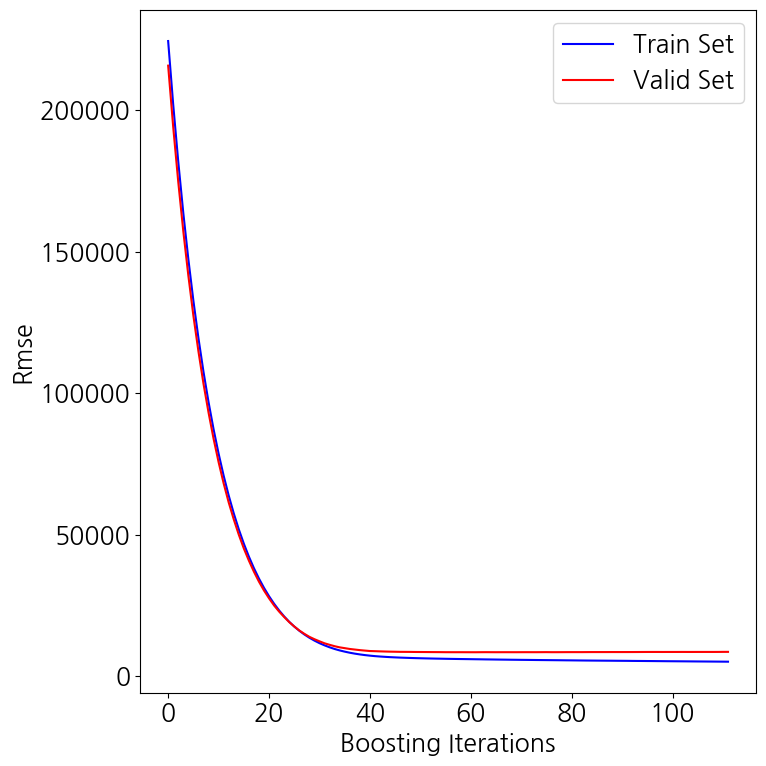

In [32]:
# 학습결과를 시각화합니다.

fig = plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.plot(np.arange(len(list(gbm_trained.evals_result_['training']['rmse']))), list(gbm_trained.evals_result_['training']['rmse']), 'b-',
         label='Train Set')
plt.plot(np.arange(len(list(gbm_trained.evals_result_['training']['rmse']))), list(gbm_trained.evals_result_['valid_1']['rmse']), 'r-',
         label='Valid Set')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Rmse')
fig.tight_layout()
plt.show()

- train rmse와 valid rmse모두 함께 감소하는 모습을 확인할 수 있습니다.

##### ✔ Predict visualize
- 실제 예측결과를 다양한 관점에서 시각화합니다.
- 모델의 예측결과를 수치적인 지표를 통해서 하나하나 비교하기에는 한계가 있습니다.
  - 모델의 예측결과를 시각화하면서 문제점을 찾고 개선의 방향을 탐색할 수 있습니다.



**✅ 종목 별 rmse를 시각화합니다.**

In [33]:
# 종목별로 valid set에 대한 rmse를 측정합니다.

code_li = list(X_valid['LEncodedCode'].unique())  # 종목리스트를 만듭니다.

valid_rmse_li = []                                # 종목별 rmse를 저장할 리스트를 선언합니다.
for code in code_li:                              # 종목별로 rmse측정을 진행합니다.
  valid_sets = X_valid.loc[X_valid['LEncodedCode']==code] # 해당 종목의 input을 가져옵니다.

  valid_predicts = gbm_trained.predict(valid_sets, verbosity=-1) # 추론을 진행합니다.

  valid_rmse_li.append(mean_squared_error(Y_valid[valid_sets.index], valid_predicts)**0.5) # 추론결과로 rmse를 계산하고 저장합니다.

In [34]:
# 종목별 rmse결과를 dataframe형태로 바꾸고, 오름차순으로 정렬합니다.

valid_rmse_df = pd.DataFrame({'code':code_li, 'rmse':valid_rmse_li})
valid_rmse_df = valid_rmse_df.sort_values(by='rmse', ascending=True).reset_index(drop=True)

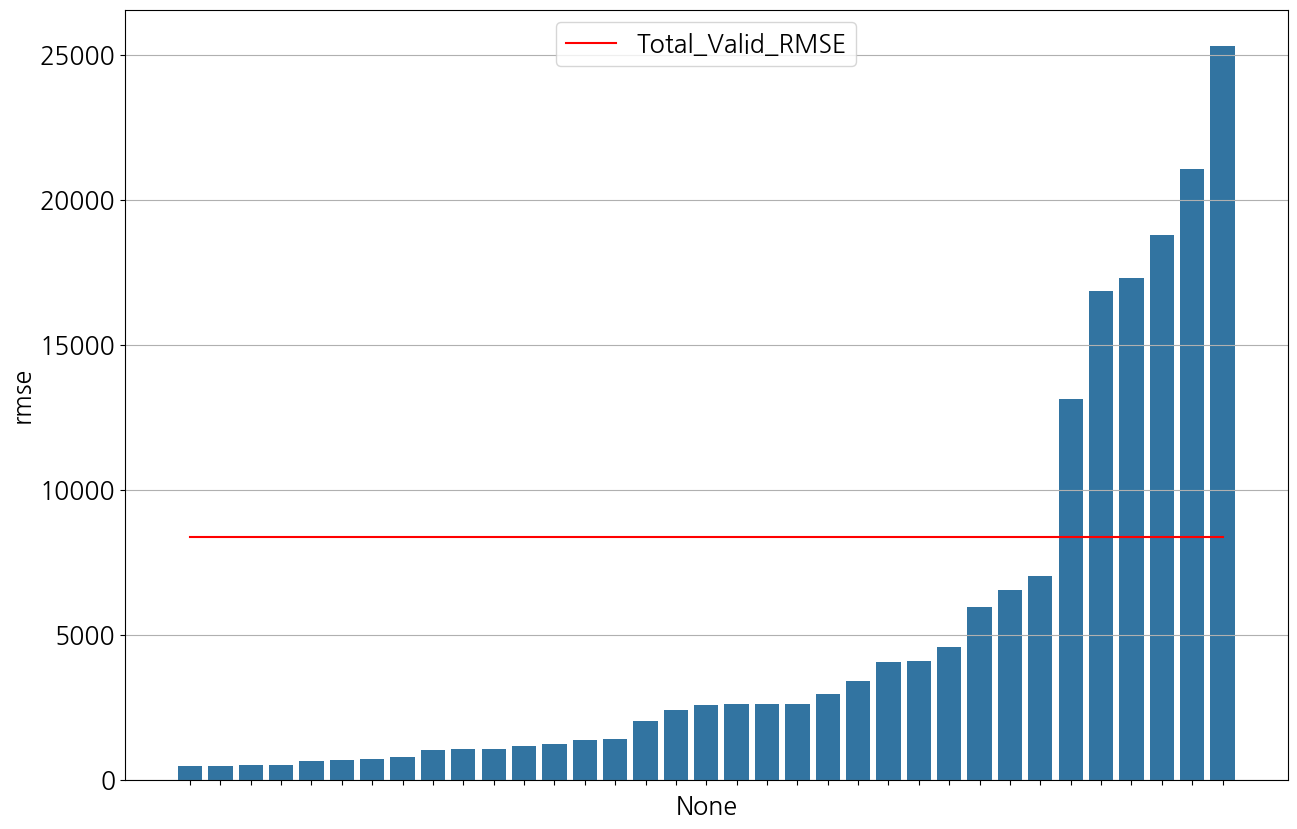

In [35]:
# 시각화를 진행합니다.
# 이전 코드 셀에서 'valid_rmse_df'를 만드는 부분이 반드시 먼저 실행되어야 합니다.

plt.figure(figsize=(15,10))
barplot = sns.barplot(
    data=valid_rmse_df,            # 종목별 rmse를 barplot으로 시각화합니다.
    x="code",
    y="rmse",
    order=valid_rmse_df['code']
)
barplot.set(xticklabels=[])        # 종목명을 그래프에 모두 표현하기에는 너무 좁기에, 종목명은 시각화에서 제외합니다.
barplot.set(xlabel=None)

sns.lineplot(
    x=valid_rmse_df.index,
    y=[RMSE] * len(valid_rmse_df),
    label="Total_Valid_RMSE",
    color='red'
)  # 전체 validset에 대한 rmse를 lineplot으로 시각화합니다.

plt.legend(loc='upper center')
plt.grid(True, axis='y')
plt.show()

- 종목별로 시각화를 했을때, 전체 valid rmse보다 매우 낮거나 큰 rmse를 가지는 종목들이 있다는 점을 한눈에 확인할 수 있습니다.
- 전체 valid rmse보다 차이가 큰 종목들을 비교하면서 모델의 개선방향을 탐색할 수 있습니다.

**✅ 종목 별 예측을 시각화합니다.**

- 앞서 시각화한 종목들에서, 전체 valid rmse보다 매우 높게 나타난 3개의 종목과 매우 낮게 나타난 3개의 종목을 각각 시각화 해봅니다.

In [36]:
# 높게 나타난 3개의 종목을 추출합니다.
high_rmse_sample = valid_rmse_df.tail(3) # 이전의 rmse기준으로 오름차순으로 정렬된 dataframe에서 끝부분 3개를 가져옵니다.

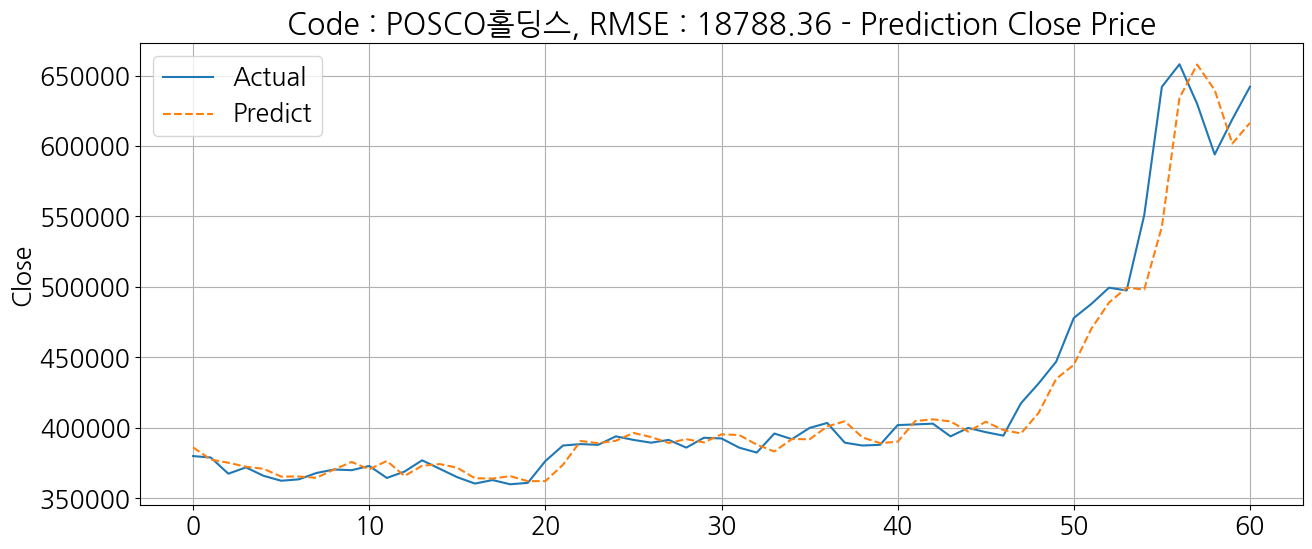

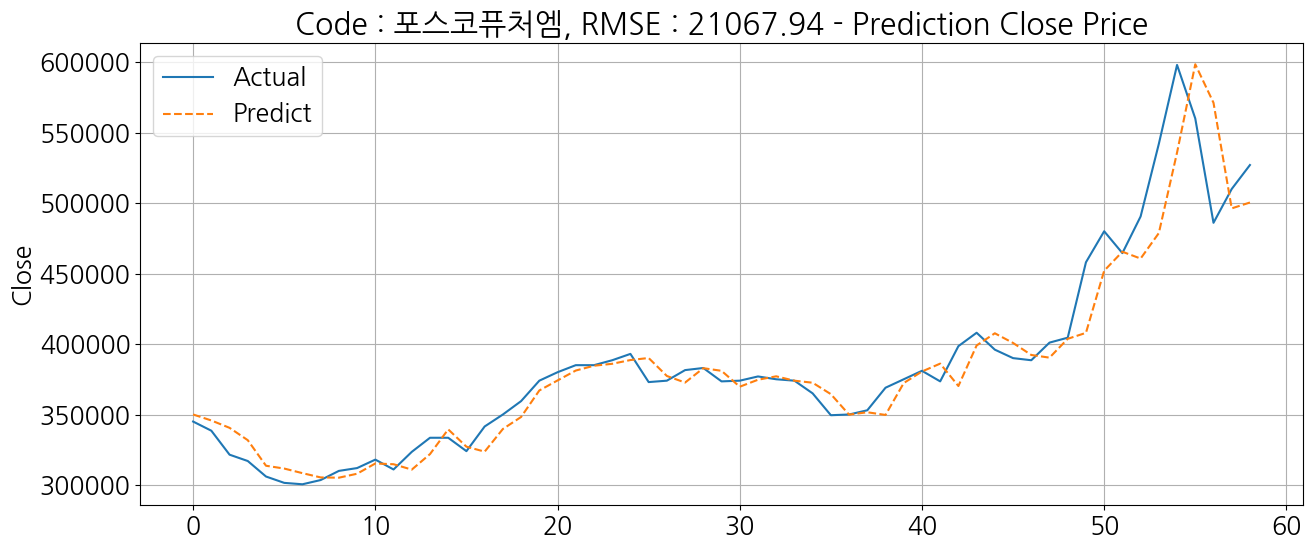

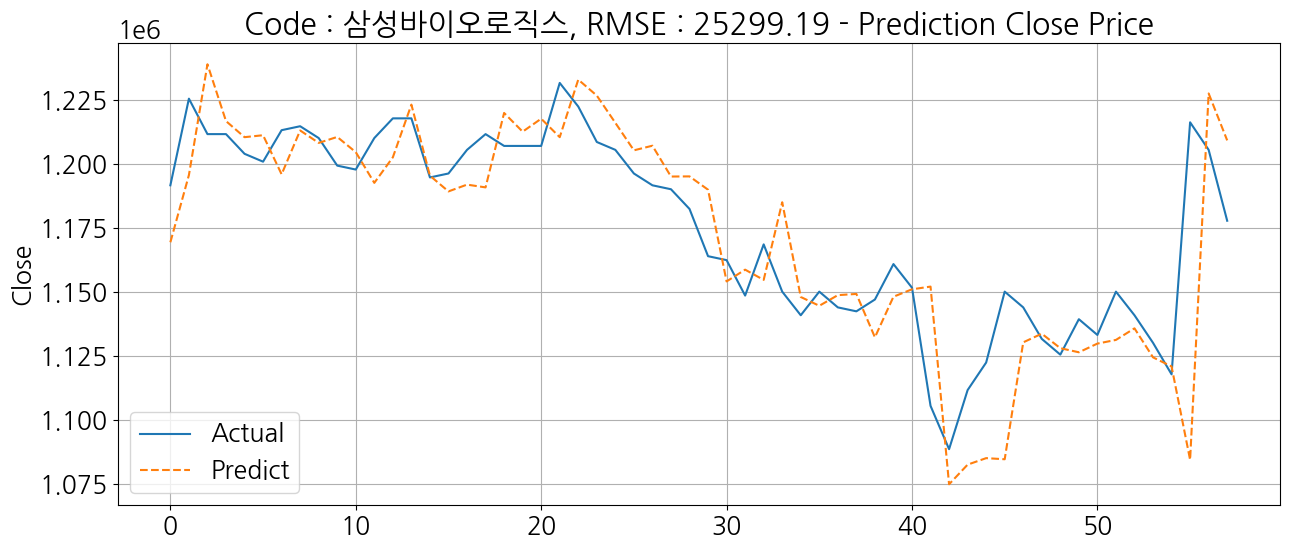

In [37]:
# 각 종목별로 예측결과와 실제결과를 함께 시각화합니다.

for idx, row in high_rmse_sample.iterrows():
  code_input = X_valid.index[X_valid['LEncodedCode'] == row['code']].tolist()  # 검증세트의 입력에서 해당 종목의 인덱스를 가져옵니다.

  plt.figure(figsize=(15,6))
  sns.lineplot(x=range(0, len(code_input)), y=np.asarray(Y_valid)[code_input], label="Actual", alpha=1.0)  #  실제 결과들 중 앞선 인덱스를 통해 해당 종목의 실제값만 가져옵니다.
  sns.lineplot(x=range(0, len(code_input)), y=predicts[code_input], label="Predict", alpha=1.0, linestyle='--') # 예측 결과들 중 앞선 인덱스를 통해 해당 종목의 예측값만 가져옵니다.
  origin_code = code_label_encoder.inverse_transform([int(row['code'])])[0] # 종목을 label encoding하기 전의 원본코드값으로 변환합니다.
  code_name = company_data.loc[company_data['code']==origin_code]['company'].values[0] # company data에서 원본코드값에 매칭되는 종목명을 가져옵니다.
  plt.title(f"Code : {code_name}, RMSE : {row['rmse']:.2f} - Prediction Close Price")
  plt.ylabel('Close')
  plt.legend()
  plt.grid(True)
  plt.show()

In [38]:
# 낮게 나타난 3개의 종목을 추출합니다.
low_rmse_sample = valid_rmse_df.head(3) # 이전의 rmse기준으로 오름차순으로 정렬된 dataframe에서 앞부분 3개를 가져옵니다.

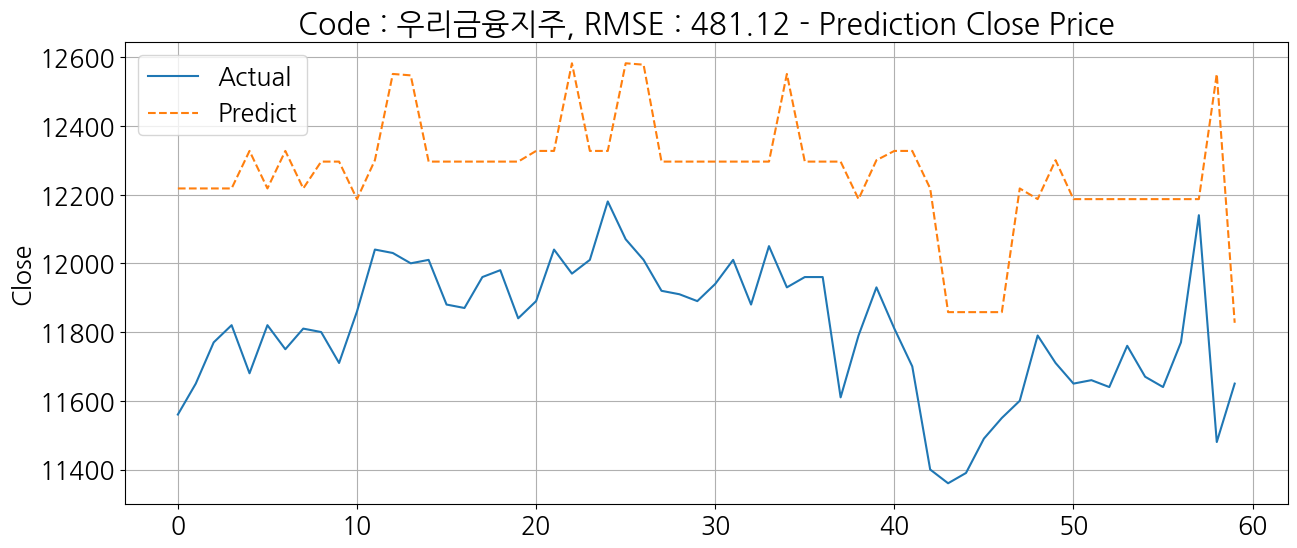

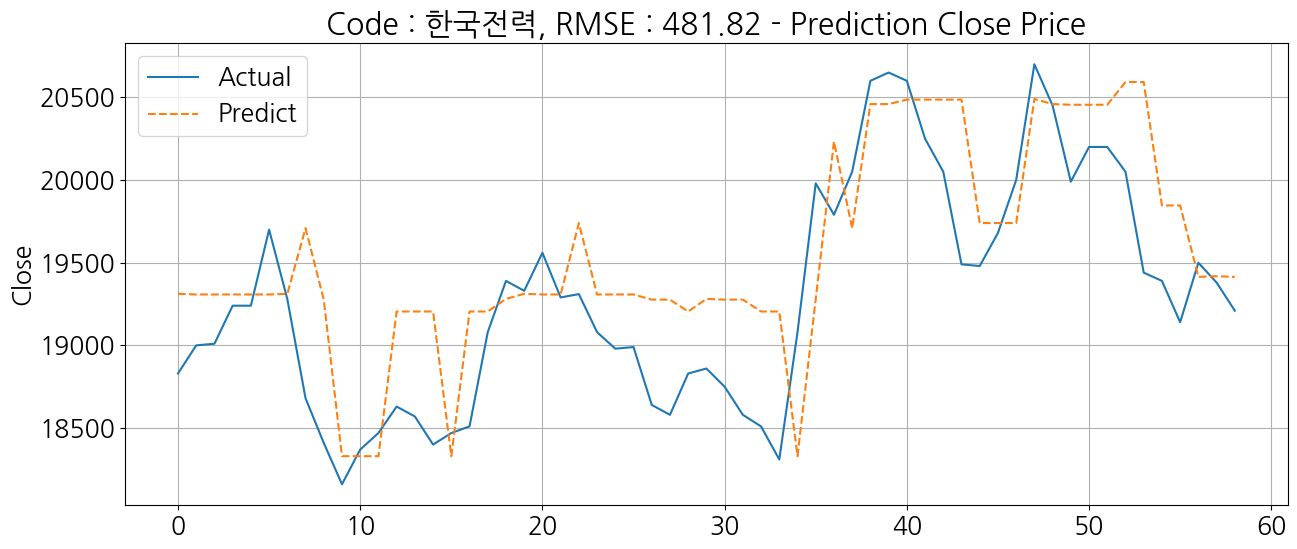

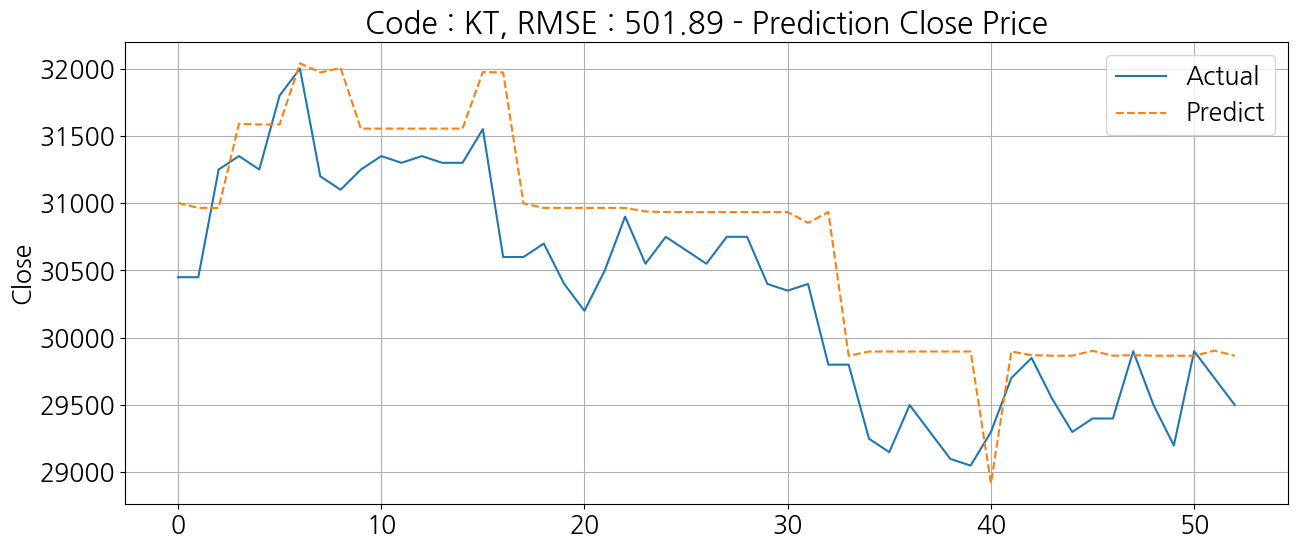

In [39]:
# 각 종목별로 예측결과와 실제결과를 함께 시각화합니다.

for idx, row in low_rmse_sample.iterrows():
  code_input = X_valid.index[X_valid['LEncodedCode'] == row['code']].tolist()  # 검증세트의 입력에서 해당 종목의 인덱스를 가져옵니다.

  plt.figure(figsize=(15,6))
  sns.lineplot(x=range(0, len(code_input)), y=np.asarray(Y_valid)[code_input], label="Actual", alpha=1.0)  #  실제 결과들 중 앞선 인덱스를 통해 해당 종목의 실제값만 가져옵니다.
  sns.lineplot(x=range(0, len(code_input)), y=predicts[code_input], label="Predict", alpha=1.0, linestyle='--') # 예측 결과들 중 앞선 인덱스를 통해 해당 종목의 예측값만 가져옵니다.

  origin_code = code_label_encoder.inverse_transform([int(row['code'])])[0] # 종목을 label encoding하기 전의 원본코드값으로 변환합니다.
  code_name = company_data.loc[company_data['code']==origin_code]['company'].values[0] # company data에서 원본코드값에 매칭되는 종목명을 가져옵니다.
  plt.title(f"Code : {code_name}, RMSE : {row['rmse']:.2f} - Prediction Close Price")
  plt.ylabel('Close')
  plt.legend()
  plt.grid(True)
  plt.show()

- rmse가 높게 측정 되어지는 종목과, 낮게 측정 되어지는 종목을 구분해서 확인하며 차이점을 탐색할 수 있습니다.
- rmse가 높게 나타난 종목의 첫번째 그래프를 기준으로 보면, 아래의 rmse가 낮은 3개의 종목보다 예측의 경향은 더 알맞게 fitting되었지만 rmse가 더 높게 측정되었습니다.
  - Y축을 통해 비교해보면, 예측해야할 Y의 값이 큰 값일 경우 rmse가 더욱 높게 측정되는 문제점을 확인할 수 있었으며 개선의 방향을 찾을 수 있습니다.
  - 예시) 모델이 학습에서 update를 위한 gradient를 계산할 때, 예측과 실제값 그대로의 차이를 이용해 계산하는 Loss함수가 아닌 함수를 탐색하고 적용하여 개선방향을 설정할 수 있습니다.

**✅ 산업군 별 rmse를 시각화합니다.**

In [40]:
# 산업군별로 valid set에 대한 rmse를 측정합니다.

industry_li = list(X_valid['LEncodedIndustry'].unique())  # 산업군리스트를 만듭니다.

valid_rmse_li = []                                # 산업군별 rmse를 저장할 리스트를 선언합니다.
for industry in industry_li:                              # 산업군별로 rmse측정을 진행합니다.
  valid_sets = X_valid.loc[X_valid['LEncodedIndustry']==industry] # 해당 산업군의 input을 가져옵니다.

  valid_predicts = gbm_trained.predict(valid_sets, verbosity=-1) # 추론을 진행합니다.

  valid_rmse_li.append(mean_squared_error(Y_valid[valid_sets.index], valid_predicts)**0.5) # 추론결과로 rmse를 계산하고 저장합니다.

In [41]:
# 산업군별 rmse결과를 dataframe형태로 바꾸고, 오름차순으로 정렬합니다.

valid_rmse_df = pd.DataFrame({'industry':industry_li, 'rmse':valid_rmse_li})
valid_rmse_df = valid_rmse_df.sort_values(by='rmse', ascending=True).reset_index(drop=True)

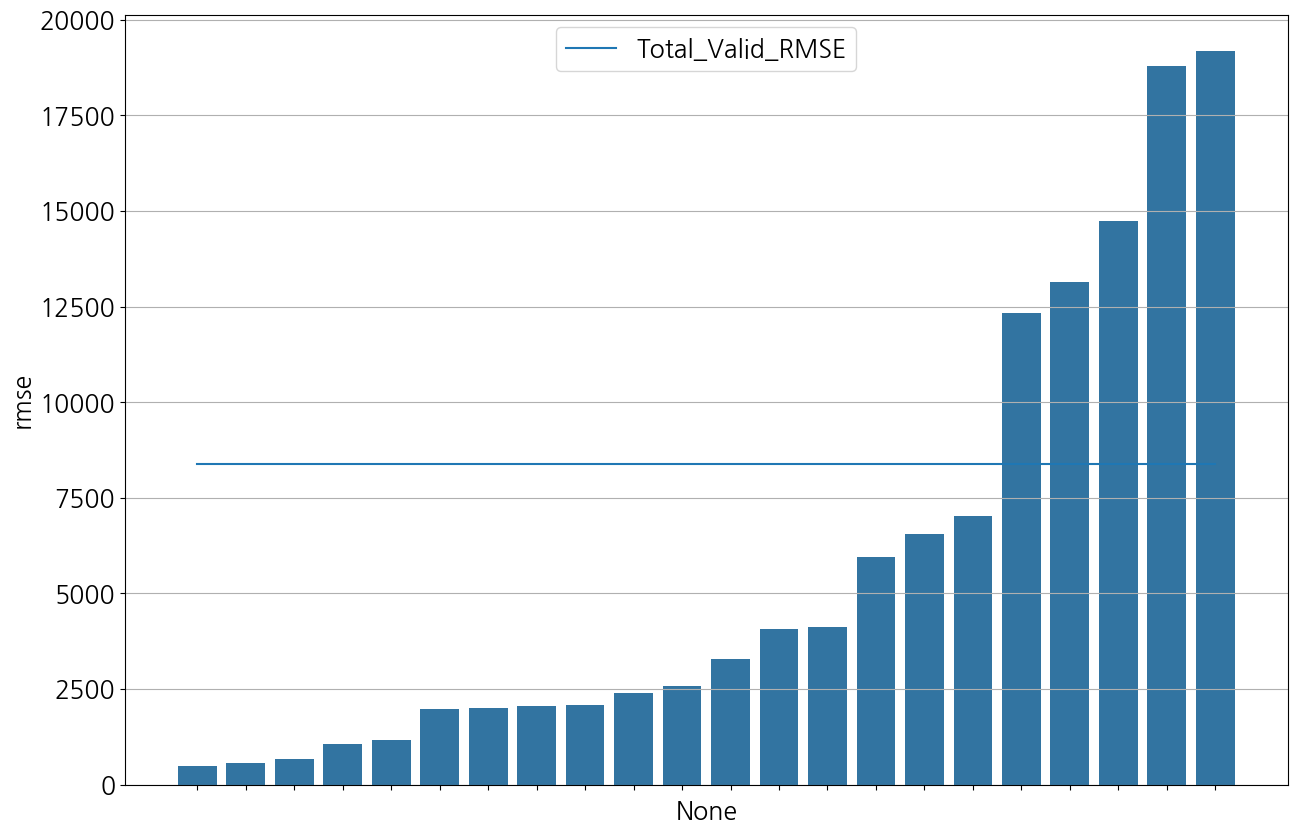

In [42]:
# 시각화를 진행합니다.

plt.figure(figsize=(15,10))
barplot = sns.barplot(data=valid_rmse_df,         # 산업군별 rmse를 barplot으로 시각화합니다.
                      x="industry",
                      y="rmse",
                      order=valid_rmse_df['industry'])
barplot.set(xticklabels=[])                       # 산업군명을 그래프에 모두 표현하기에는 너무 좁기에, 산업군명은 시각화에서 제외합니다.
barplot.set(xlabel=None)
sns.lineplot(x=valid_rmse_df['industry'].index, y=[RMSE] * len(valid_rmse_df), label="Total_Valid_RMSE")  # 전체 validset에 대한 rmse를 lineplot으로 시각화합니다.
plt.legend(loc='upper center')
plt.grid(True, axis='y')
plt.show()

- 종목별 확인값들과 유사하게, 산업군별로 시각화를 했을때, 전체 valid rmse보다 매우 낮거나 큰 rmse를 가지는 산업군들이 있다는 점을 한눈에 확인할 수 있습니다.

**✅ 산업군 별 예측을 시각화합니다.**

- 앞서 시각화한 산업군들에서, 전체 valid rmse보다 매우 높게 나타난 3개의 산업군과 매우 낮게 나타난 3개의 산업군을 각각 시각화 해봅니다.

In [43]:
# 높게 나타난 3개의 산업군을 추출합니다.
high_rmse_sample = valid_rmse_df.tail(3) # 이전의 rmse기준으로 오름차순으로 정렬된 dataframe에서 끝부분 3개를 가져옵니다.

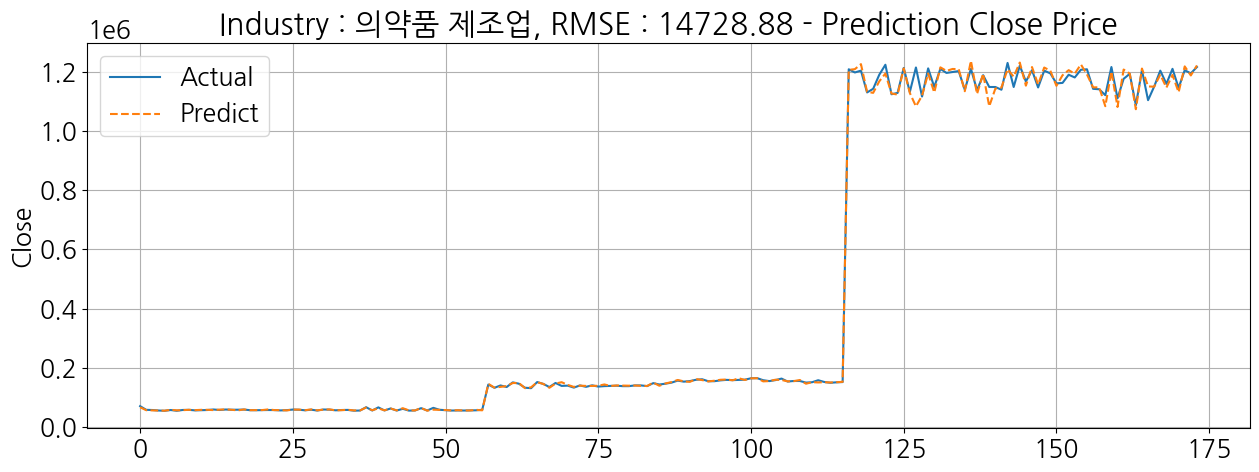

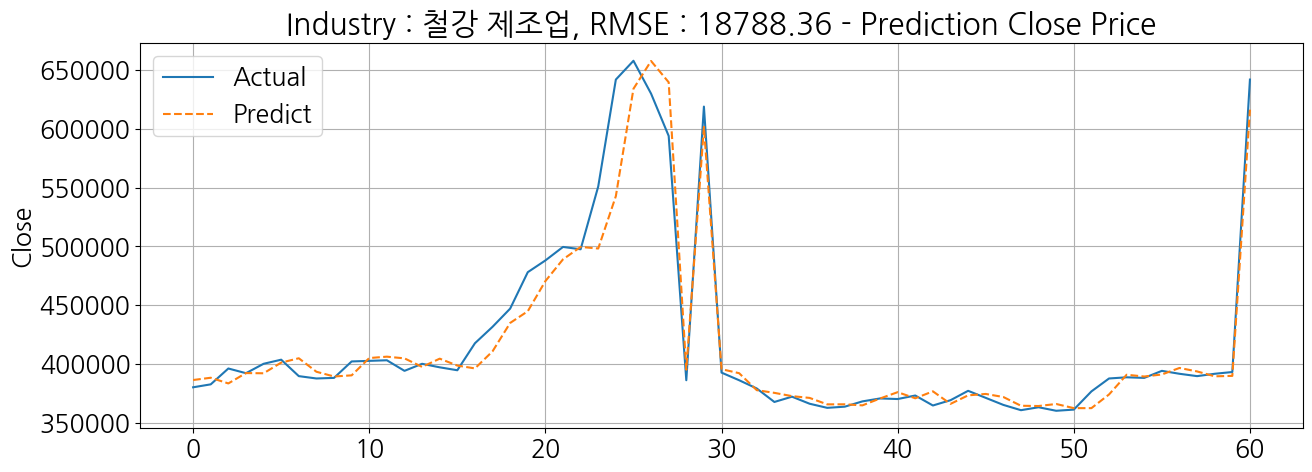

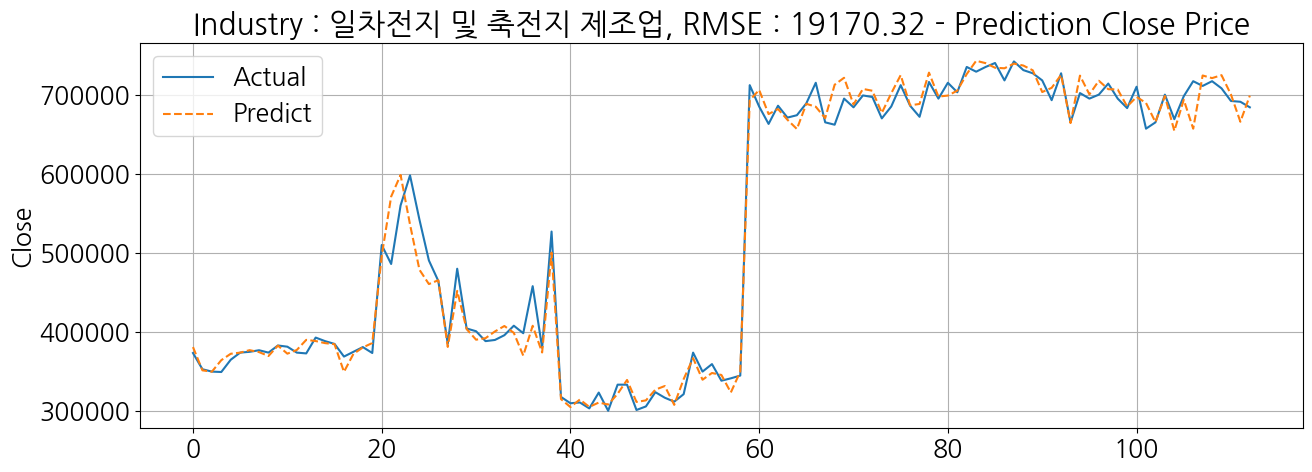

In [44]:
# 각 산업군별로 예측결과와 실제결과를 함께 시각화합니다.

for idx, row in high_rmse_sample.iterrows():
  Industry_input =   X_valid.loc[X_valid['LEncodedIndustry'] == row['industry']].sort_values(by=['LEncodedCode'], ascending=True).index.tolist()

  plt.figure(figsize=(15,5))
  sns.lineplot(x=range(0, len(Industry_input)), y=np.asarray(Y_valid)[Industry_input], label="Actual", alpha=1.0)  #  실제 결과들 중 앞선 인덱스를 통해 해당 산업군의 실제값만 가져옵니다.
  sns.lineplot(x=range(0, len(Industry_input)), y=predicts[Industry_input], label="Predict", alpha=1.0, linestyle='--') # 예측 결과들 중 앞선 인덱스를 통해 해당 산업군의 예측값만 가져옵니다.

  origin_industry = industry_label_encoder.inverse_transform([int(row['industry'])])[0] # 산업군을 label encoding하기 전의 원본산업군으로 변환합니다.
  plt.title(f"Industry : {origin_industry}, RMSE : {row['rmse']:.2f} - Prediction Close Price")
  plt.ylabel('Close')
  plt.legend()
  plt.grid(True)
  plt.show()

In [45]:
# 낮게 나타난 3개의 산업군을 추출합니다.
low_rmse_sample = valid_rmse_df.head(3) # 이전의 rmse기준으로 오름차순으로 정렬된 dataframe에서 앞부분 3개를 가져옵니다.

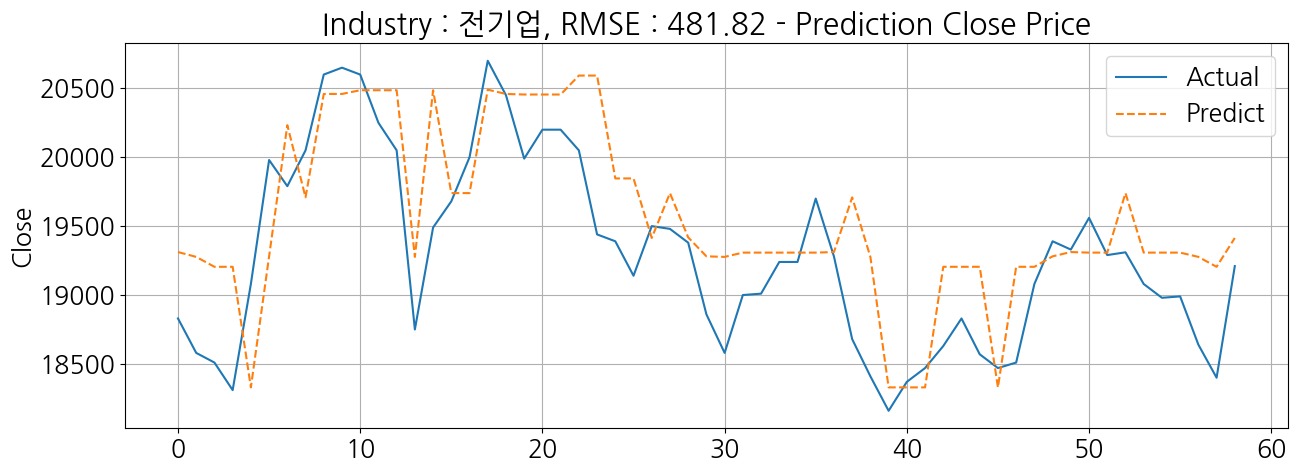

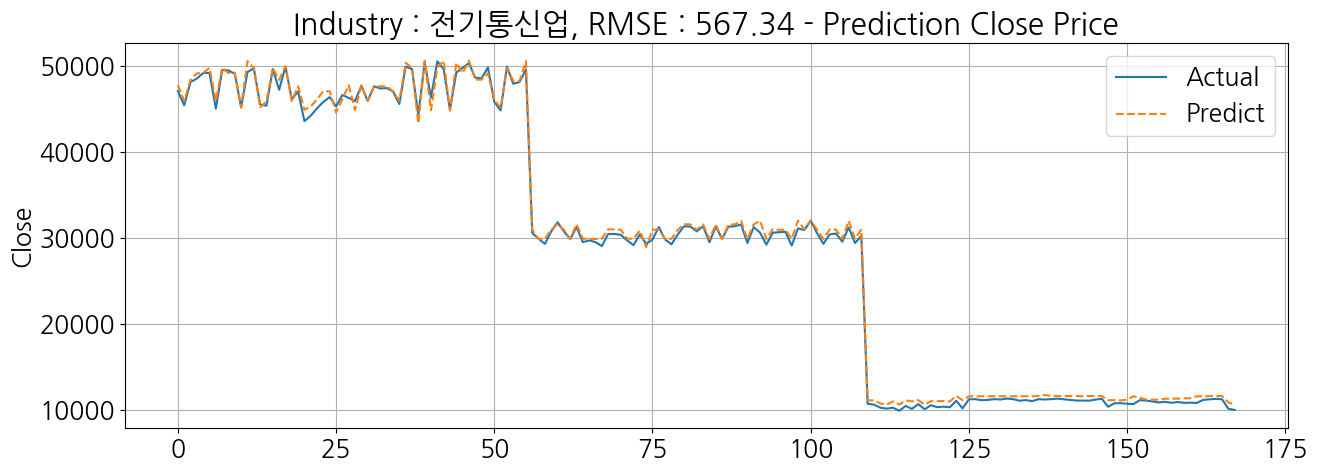

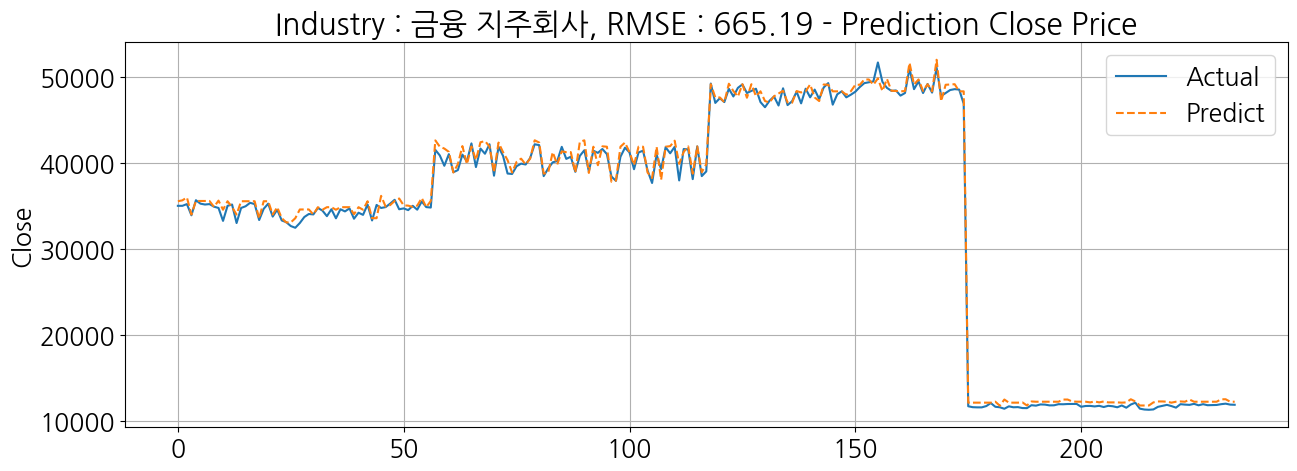

In [46]:
# 각 산업군별로 예측결과와 실제결과를 함께 시각화합니다.

for idx, row in low_rmse_sample.iterrows():
  Industry_input =   X_valid.loc[X_valid['LEncodedIndustry'] == row['industry']].sort_values(by=['LEncodedCode'], ascending=True).index.tolist()

  plt.figure(figsize=(15,5))
  sns.lineplot(x=range(0, len(Industry_input)), y=np.asarray(Y_valid)[Industry_input], label="Actual", alpha=1.0)  #  실제 결과들 중 앞선 인덱스를 통해 해당 산업군의 실제값만 가져옵니다.
  sns.lineplot(x=range(0, len(Industry_input)), y=predicts[Industry_input], label="Predict", alpha=1.0, linestyle='--') # 예측 결과들 중 앞선 인덱스를 통해 해당 산업군의 예측값만 가져옵니다.

  origin_industry = industry_label_encoder.inverse_transform([int(row['industry'])])[0] # 산업군을 label encoding하기 전의 원본산업군으로 변환합니다.
  plt.title(f"Industry : {origin_industry}, RMSE : {row['rmse']:.2f} - Prediction Close Price")
  plt.ylabel('Close')
  plt.legend()
  plt.grid(True)
  plt.show()

- 산업군을 기준으로도, RMSE가 크고 작은 산업군이 있다는 점은 명확히 확인할 수 있습니다.
- rmse가 높게 나타난 산업군의 경우 rmse가 낮게 나타난 산업군에 비해 아래와 같은 특징을 가지는 모습입니다.
  - x축이 긴 모습을 보면, 산업군에 해당하는 종목들이 많습니다.
  - 산업군에 해당하는 각 종목간에 편차가 큰 모습입니다.
  - 산업군에 해당하는 각 종목의 예측값이 큰값이기에 이전의 종목에서의 비교와 같이 rmse가 높게 측정되었습니다.
- rmse가 높은 산업군별로 rmse를 낮추는 방법을 탐색하며, 모델의 성능을 개선하는 다음의 방향으로 설정할 수 있습니다.
  - 예시) 산업군별로 특징을 나타낼 수 있는 feature를 더욱 제작합니다.

❓ 왜 낮은 rmse를 보이는 산업군의 예측결과 그래프가 실제 값보다 한칸씩 밀려서 보이는건가요??
- 위 현상은 time series price prediction에서 자주 발생하는 문제입니다.
  - 실제 stackoverflow([참고링크](https://stackoverflow.com/questions/54368686/lstm-having-a-systematic-offset-between-predictions-and-ground-truth))에서도 자주 발생하는 질문입니다.
- “전날의 종가”를 포함한 다양한 feature를 통해 “다음날의 종가”를 예측하도록 학습데이터가 구성되어 있기에, 예측 또한 실제값에 비해 조금씩 밀리는 모습을 보이게 됩니다.
  - 즉, Close에 집중되는 모습을 줄이도록 다음의 개선방향으로 사용할 수 있습니다.
  - 예시) Target값인 “미래의 종가”와 연관이 높은 “전날의 종가”를 제외하는 식의 방향으로 Feature Selection을 할 수 있으며, 단순히 제외하는 방향이 아닌 비선형 변환이나 다른 변수와의 차이 또는 평균을 취하는 등의 Feature Engineering을 시도 해 볼 수 있습니다.


##### ✔ Feature Importance
- Tree계열의 모델학습에 있어서, 각 입력 Feature들의 중요도를 시각화를 통해 확인할 수 있습니다.
- Feature간의 중요도의 차이를 수치적으로 확인하는 것보다 시각화를 통해 더욱 한눈에 확인할 수 있습니다.
- 너무 큰 연관도를 가지는 Feature를 제외하거나, 하위 K개의 Feature를 제외하는 등의 방향으로 Feature Engineering을 통해 모델의 성능을 향상 시킬 수 있습니다.


In [47]:
# 학습된 모델에서 feature importance를 불러옵니다.

feat_imp = gbm_trained.feature_importances_
print(f"GBM Feature Importance \n\n {feat_imp}")

GBM Feature Importance 

 [102 202 206 624 152 291 170 176  25   0  97  58  85  80  64  85 100 160
 144  41  49  34  36  34  34  91  34 124  72  22 106 197  28   8  12   0
  18   4   8   1   0   8]


In [48]:
# 불러온 feature importance를 feature의 이름과 함께 dataframe의 형태로 저장합니다.
# 저장 후, 가장 영향력이 강한 feature순으로 정렬합니다.

sorted_feat_imp = pd.Series(feat_imp, input_cols).sort_values(ascending=False)
print(sorted_feat_imp)

Close                 624
Change                291
Low                   206
High                  202
DateDay               197
AveragePrice          176
PriceRange            170
LongEMA               160
Volume                152
MACD                  144
VolumeMean            124
DateMonth             106
Open                  102
ShortEMA              100
MovingAverage5d        97
CloseMean              91
LowerBollingerBand     85
MovingAverage60d       85
MovingAverage120d      80
VolumeMedian           72
UpperBollingerBand     64
MovingAverage20d       58
OpenMedian             49
OpenMean               41
HighMedian             36
CloseMedian            34
HighMean               34
LowMedian              34
LowMean                34
ListingDateYear        28
PriceDirection         25
DateYear               22
LEncodedIndustry       18
ListingDateDay         12
ListingDateMonth        8
LEncodedProducts        8
TEncodedIndustry        8
LEncodedCode            4
LEncodedRegi

Text(0, 0.5, 'Feature Importance Score')

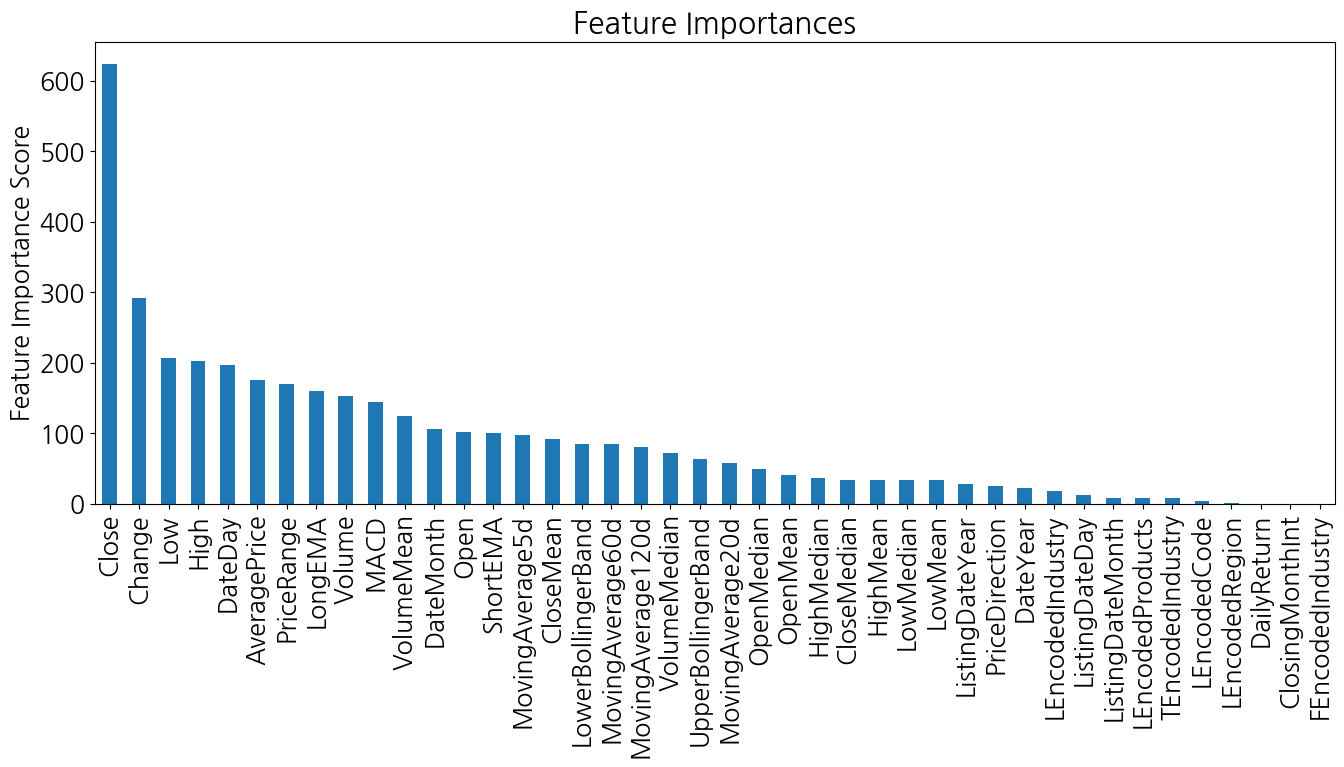

In [49]:
# 구성된 feature importance 결과를 시각화합니다.

plt.figure(figsize=(16,6))
sorted_feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

- Close가 가장 높은 중요도를 보이며, DailyReturn과 ClosingMonthInt의 중요도는 매우 낮게 나타납니다.
- 낮은 중요도를 보이는 Feature를 제거하는 방식의 Feature Selection으로 모델의 성능 개선방향을 설정할 수 있습니다.
- 너무 높은 Importance를 보이는 Feature에 대해 별도의 Engineering과정을 추가할 수 있습니다.

##### ✔ Plot Tree
- Tree계열의 모델학습에 있어서, Tree의 각 노드가 어떻게 연결되어 있는지 한눈에 확인할 수 있습니다.
- 각 분기점들의 Feature와 수치, Tree의 깊이와 넓이 등을 보다 쉽게 파악할 수 있으며, 이를 통해 추가적인 Feature Engineering이나 max depth의 조절과 같은 Parameter 튜닝의 방향으로 모델의 다음 개선과정을 탐색할 수 있습니다.


<Axes: >

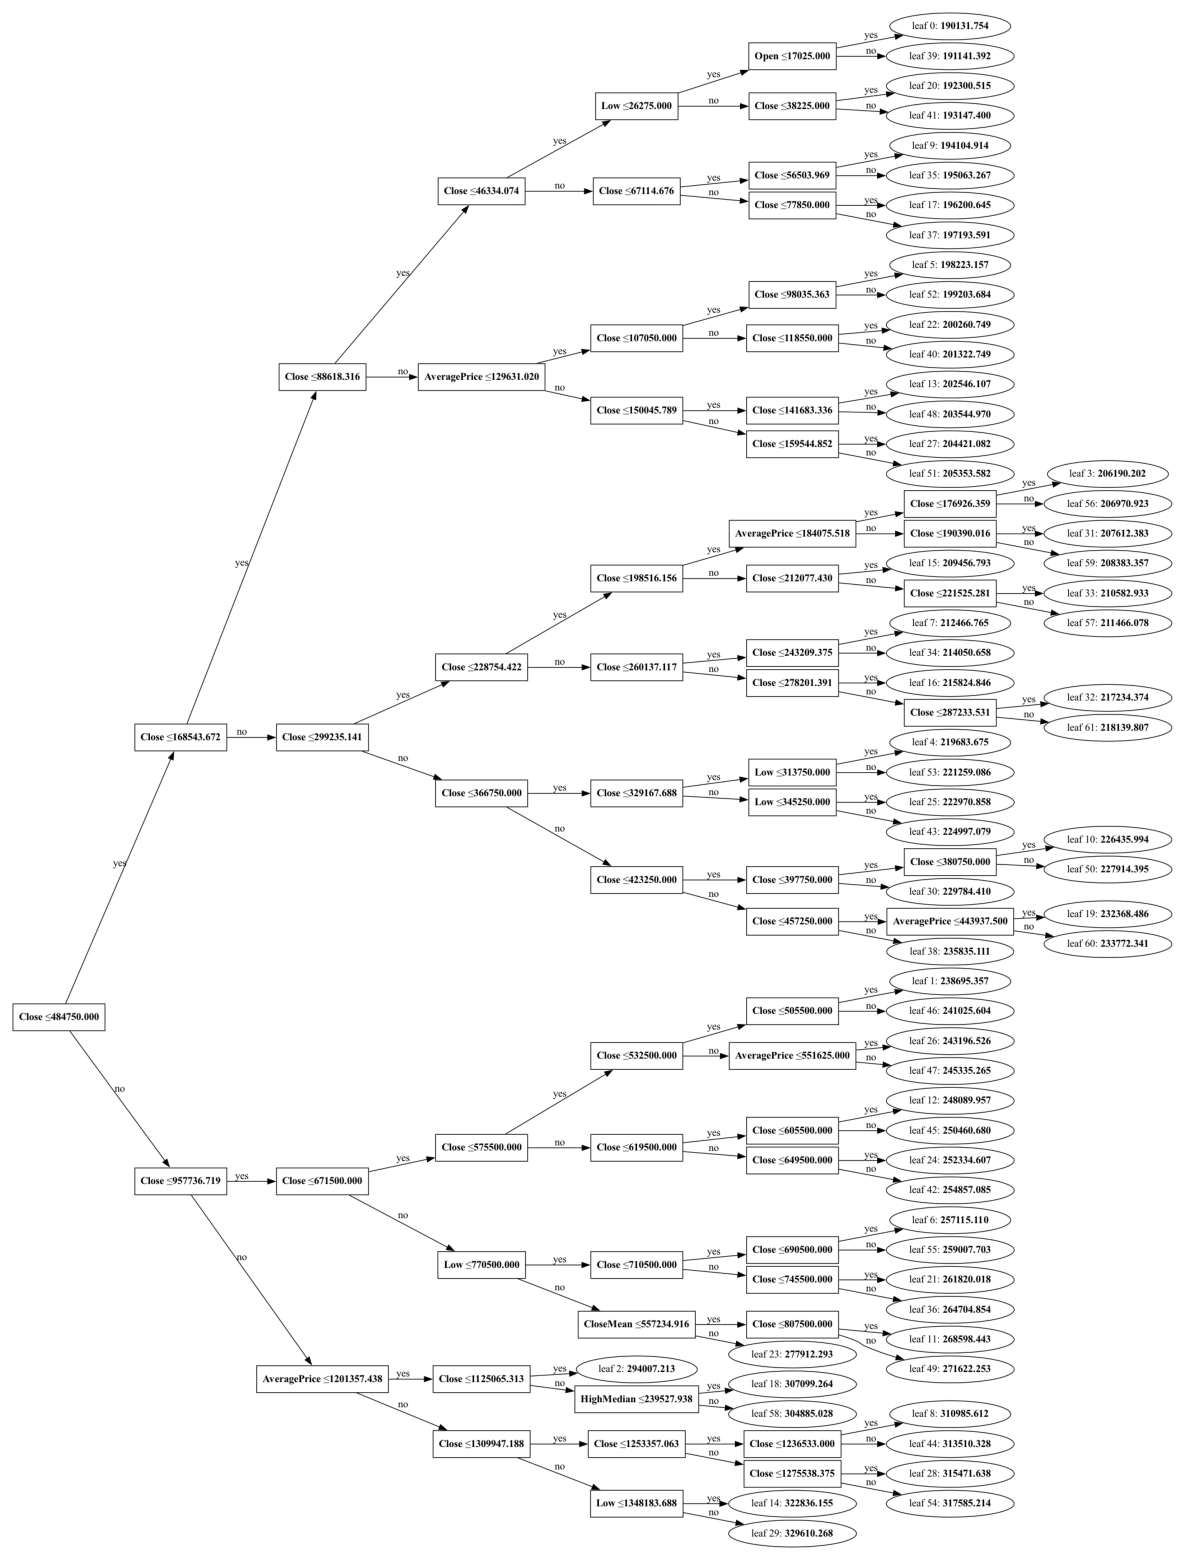

In [50]:
lgb.plot_tree(gbm_trained,
              figsize=(50,20))

- 상위 분기에 Close가 집중되는 모습을 확인할 수 있습니다.
  - 보다 다양한 Feature를 사용한 Tree를 구성하기 위해, Close Feature에 대해 별도의 Engineering을 시도해 볼 수 있습니다.
- 더욱 많은 Feature로 Tree가 구성될 수 있도록, 트리의 깊이를 늘리거나 leaf수를 늘리는 방향으로도 시도해 볼 수 있습니다.

#### 📚 자료


- [Plotting - Scikit-Learn 공식문서](https://lightgbm.readthedocs.io/en/latest/Python-API.html#plotting) : Lightgbm모델의 다양한 plotting을 확인할 수 있습니다.


#Reference

- [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)
- [Scikit-Learn](https://scikit-learn.org/stable/index.html)